# Movie Recommendation Engine
### Final Project
#### Dhananjay Kumar

### 1.Introduction

In this project we focus on Movie Recommendation engine. Content Based and Collaborative filtering are two of the most popular techniques in recommendation problems.
In this project we focus more advance techniques used for recommendation problems. Here we use matrix factorization technique called Alternating least squares(ALS) to get movie to mvie recommendations.

In [79]:
import numpy as np
import pandas as pd
from numpy.linalg import solve
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### 2. Data

We have used MOvieLens data set for this analysis.The data set consisits of nearly 100k ratings on a scale of 1-5.The main data file consists of ratings given by users for a movie.The other data we will use is the description of each movie (MovieID -> Movie Title), which we will use in final recommndation.

In [80]:
df = pd.read_csv('ratings.csv')
df.columns = ['user_id','item_id','rating','timestamp']
#df.head(5)

In [81]:
df.shape

(100004, 4)

In [82]:
df.head(5)

,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [83]:
n_users = df.user_id.unique().shape[0] # get number of unique user ids in the data set # 671
n_items = df.item_id.unique().shape[0] # get no: if unique movie ids # 9066
ratings = np.zeros((n_users, n_items)) # create a zero matrix


In [84]:
n_users

671

In [85]:
n_items

9066

In [86]:
R_df = df.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
# R_df

In [87]:
ratings = R_df.as_matrix()

In [88]:
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [89]:
print(str(n_users) + ' users')
print(str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

671 users
9066 items
Sparsity: 1.64%


This means 1.64% have values

Here we will create the training and testing data sets. In order to create the testing data set, we will take 3 ratings from each user and put it in the testing dataset, which will be used for evaluating the recommendation engine.

In [90]:
# We will take 3 ratings from each user and put it in the testing data set
def train_test(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user,:].nonzero()[0],
                                       size=3,
                                       replace=False)
        train[user,test_ratings] = 0.
        test[user,test_ratings] = ratings[user, test_ratings]
        
        # Ensure Test and training set are truly disjoint
        assert(np.all((train*test) == 0))
        return (train, test)

In [91]:
train, test=train_test(ratings)

### 3. Alternating Least Squares

The idea behind Matrix Factorization is the following:

-  Each user can be described by m features. Each feature can describe any attribute of a user for example how much a user likes comedy movies or movie from a particular director, actor etc.

-  Similarly each item (movie in our case) can also be described by n features.

-  If we multiply each feature of a user to it's corresponding feature of an item and add everything, then this would be a good approximation of the rating, that user would give to that movie

In matrix factorization we don't know, what these features are and how many features to take. We simply pick k number of features as input to our learning algorithm, that learns those features

This is our approximation of rating matrix:

**$r_{ij}$ = $x^{T}_{i}$.$y_{j}$ = $\sum\limits_{k} x_{ik}y_{ki}$**

The objective here is to minimize the difference of sum of squared values of actual and predicted ratings.

In ALS model, we hold one set of latent factors constant at a time. For example, we will hold the movie vectors constant and then take derivative of loss function with respect to user vectors. We will set the derivative to zero in order to obtain minimization.
Next we will hod the user vectors constant and then take derivative of the loss function with respect to movie vectors, setting the derivative to zero.
We do this process alternatively until convergence.

In [92]:
class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train ALS model to predict unknown
        entries in rating matrix. 
        
        Parameters
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
    
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return (self.user_vecs[u, :].dot(self.item_vecs[i, :].T))
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [93]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [94]:
MF_ALS = ExplicitMF(ratings, n_factors=40, 
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [95]:
sns.set()
def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

The below graph suggests overfitting.As the model performs well on the training data but does not do well on the testing data

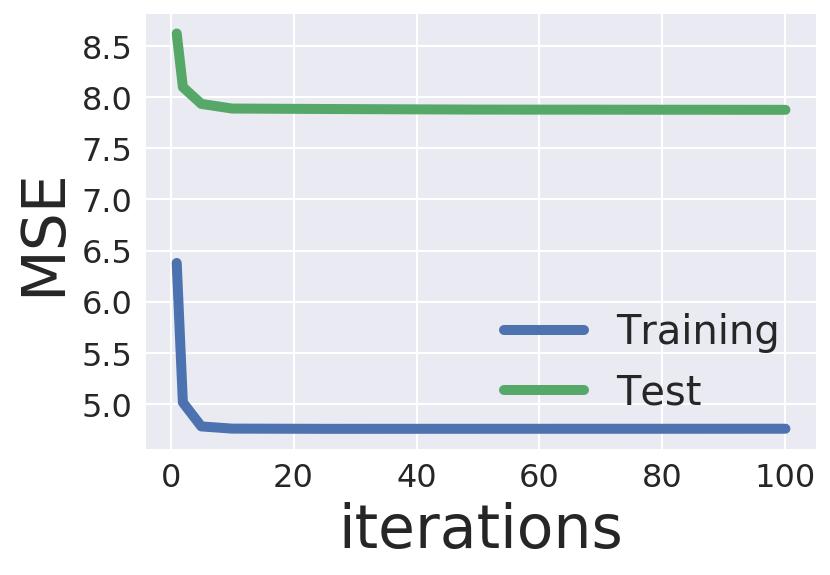

In [96]:
plot_learning_curve(iter_array, MF_ALS)

### 4. Optimizing ALS Parameters

To overcome overfitting problem, we will add regularization parameters

In [97]:
latent_factors = [10, 20, 40]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [ 5, 10, 25, 50,100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

Factors: 10
Regularization: 0.1
New optimal hyperparameters
model        <__main__.ExplicitMF object at 0x7fa000214518>
n_factors                                                10
n_iter                                                  100
reg                                                     0.1
test_mse                                            8.42984
train_mse                                           6.88763
dtype: object
Regularization: 1.0
New optimal hyperparameters
model        <__main__.ExplicitMF object at 0x7fa000264b70>
n_factors                                                10
n_iter                                                   10
reg                                                       1
test_mse                                            8.40586
train_mse                                           7.00394
dtype: object
Regularization: 10.0
Regularization: 100.0
Factors: 20
Regularization: 0.1
New optimal hyperparameters
model        <__main__.ExplicitMF object 

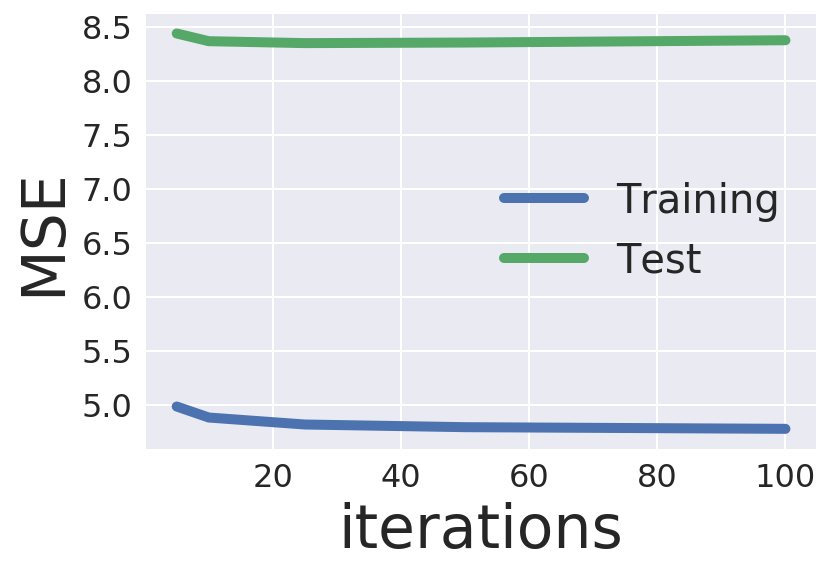

In [98]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

In [99]:
best_params

{'model': <__main__.ExplicitMF at 0x7fa003c11588>,
 'n_factors': 40,
 'n_iter': 25,
 'reg': 0.1,
 'test_mse': 8.348103085170408,
 'train_mse': 4.817375029099992}

In [100]:
# Modifying ALS model
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='als',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning

        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)

    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')

            ctr += 1


    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter


### 5. Making Recommendations

We will see movie-to-movie similarity by visualizing the top-5 most similar movies for an input movie. We’ll use the cosine similarity of the item latent vectors to calculate the similarity

In [101]:
# ALS model with best parametres 
best_als_model = ExplicitMF(ratings, n_factors=20, learning='als',item_fact_reg=1.0, user_fact_reg=1.0)
best_als_model.train(100)

In [102]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


In [103]:
als_sim = cosine_similarity(best_als_model)

Adding another data set that contains mapping of Movie Id to Movie Title

In [104]:
df_movie=pd.read_csv('movies.csv')

In [105]:
df_movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [106]:
df_movie.shape

(9125, 3)

In [107]:
idx_to_movie = dict(zip(df_movie.movieId, df_movie.title))

In [108]:
def display_top_k_movies(similarity,movie_idx, k=5):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]

    k_ctr = 0
    i = 1
    while k_ctr < 5:
        
        movie = movie_indices[i]
        print(idx_to_movie[movie])

        k_ctr += 1
        i += 1

In [109]:
idx=7
display_top_k_movies(als_sim,idx,5)

Kazaam (1996)
Good Morning, Vietnam (1987)
Richie Rich (1994)


KeyError: 4400

In [ ]:
idx=5
display_top_k_movies(als_sim,idx,5)